# Earthquake event shakemap assesment: M 7.4 - 15 km S of Hualien City, Taiwan



_Last updated: 01.05.2024_




# Scripts and Functions  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
import os  # This might be used for file path operations if needed.

import json
import xml.etree.ElementTree as ET
from pyproj import CRS, Transformer
import re
import math
#import cartopy.crs as ccrs
import zipfile
#import cartopy.feature as cfeature
#

In [2]:
from modules.SHAKEparser import *


# Set the default font family and size for matplotlib
plt.rcParams['font.family'] = 'Arial'  # Change 'Arial' to your preferred font
plt.rcParams['font.size'] = 12         # Change to your preferred font size

# Optionally, set specific sizes for titles, axes labels, and tick labels
plt.rcParams['axes.titlesize'] = 14    # Title font size
plt.rcParams['axes.labelsize'] = 12    # Axes labels font size
plt.rcParams['xtick.labelsize'] = 10   # X-axis tick labels font size
plt.rcParams['ytick.labelsize'] = 10   # Y-axis tick labels font size


# USGS ShakeMaps
## Dock Shakemap Data files  

In [3]:
# Docking file paths

event_id = 'us7000m9g4'

# load files 
file_path_eventxml='./example_data/us7000m9g4/current/event.xml'

event_attributes = {
    'id': 'us7000m9g4',
    'netid': 'USGS',
    'network': 'USGS National Earthquake Information Center, PDE',
    'lat': '23.8190',
    'lon': '121.5616',
    'depth': '34.8',
    'mag': '7.4',
    'time': '2024-04-03T01:58:11Z',
    'locstring': '18 km SSW of Hualien City, Taiwan',
    'event_type': 'Scenario',
    'reviewed': 'unknown'
}

file_path_instrument_data = "./example_data/us7000m9g4/current/instrumented_dat.json"

file_path_dyfixml = './example_data/us7000m9g4/current/dyfi_dat.xml'
file_path_dyficsv = './example_data/us7000m9g4/current/us7000m9g4_dyfi_dat.csv'
file_path_rupturedata = './example_data/us7000m9g4/current/rupture.json'  # Replace with actual file path
file_path_model_config = './example_data/us7000m9g4/current/model_select.conf'
file_path_pagerxml = './example_data/usgs-pager-versions-us7000m9g4/us7000m9g4/us7000m9g4_us_10_pager.xml'  # Change to the actual path of your XML file
raster_shakemap_file_path = "./example_data/usgs-shakemap-versions-us7000m9g4/us7000m9g4/us7000m9g4_us_011_raster.zip"
xml_shakemap_file_path = "./example_data/usgs-shakemap-versions-us7000m9g4/us7000m9g4/us7000m9g4_us_011_grid.xml"


## Event Source 

### Parse [event.xml]

In [3]:
parser = USGSParser(parser_type='event_xml', mode='parse', event_xml=file_path_eventxml)
event_df = parser.to_dataframe()
print("Earthquake Event Data DataFrame:")
parser.get_summary()




Event XML parsed successfully.
Earthquake Event Data DataFrame:
Earthquake Event Summary:
ID: us7000m9g4
Network ID: USGS
Network: USGS National Earthquake Information Center, PDE
Latitude: 23.819
Longitude: 121.5616
Depth (km): 34.8
Magnitude: 7.4
Time: 2024-04-03T01:58:11Z
Location String: 18 km SSW of Hualien City, Taiwan
Event Type: Scenario
Reviewed: unknown


### Create [event.xml]

In [4]:
# Creating a new XML based on user input
"""
attributes = {
    'id': 'us7000m9g4',
    'netid': 'USGS',
    'network': 'USGS National Earthquake Information Center, PDE',
    'lat': '23.8190',
    'lon': '121.5616',
    'depth': '34.8',
    'mag': '7.4',
    'time': '2024-04-03T01:58:11Z',
    'locstring': '18 km SSW of Hualien City, Taiwan',
    'event_type': 'Scenario',
    'reviewed': 'unknown'
}

"""
creator = USGSParser(parser_type='event_xml',mode='create', event_attributes=event_attributes)
#creator = USGSParser(data_type='event_xml', mode='create',event_id='us7000m9g4', event_attributesattributes)
#creator = USGSParser(data_type='event_xml',mode='create', event_id='us7000m9g4', file_path='./event_data', event_attributes=attributes)
#creator = USGSParser(data_type='event_xml',mode='create',file_path='./event_data', event_attributes=attributes)
#creator.write_event_xml()

Attributes initialized successfully, XML file not yet created.


## Model Selection 

In [5]:
#file_path = './example_event/us7000m9g4/current/model_select.conf'

file_path_model_config = './example_data/us7000m9g4/current/model_select.conf'

# For parsing model configuration data:
parser = USGSParser(parser_type='model_config', mode='parse', config_file=file_path_model_config)
#config_dict = parser.get_model_config()
#config_dict


# print used GMPE's
parser.print_used_gmpes()


'active_crustal_taiwan_deep'  [0.6691643912838412]
  ASK14tw [0.3333]: AbrahamsonEtAl2014RegTWN from openquake.hazardlib.gsim.abrahamson_2014
  CB14 [0.3333]: CampbellBozorgnia2014 from openquake.hazardlib.gsim.campbell_bozorgnia_2014
  CY14 [0.3334]: ChiouYoungs2014 from openquake.hazardlib.gsim.chiou_youngs_2014
'subduction_interface_nshmp2014'  [0.33083560871615886]
  AB03i [0.1]: AtkinsonBoore2003SInter from openquake.hazardlib.gsim.atkinson_boore_2003
  Zea16i [0.3]: ZhaoEtAl2016SInter from openquake.hazardlib.gsim.zhao_2016
  AM09 [0.3]: AtkinsonMacias2009 from openquake.hazardlib.gsim.atkinson_macias_2009
  Aea15i [0.3]: AbrahamsonEtAl2015SInter from openquake.hazardlib.gsim.abrahamson_2015



In [6]:
# create a dictionary from used GMPE's 
used_gmpe = parser.get_used_gmpes()
used_gmpe

{'active_crustal_taiwan_deep': {'set_weight': 0.6691643912838412,
  'gmpes': [{'gmpe_name': 'ASK14tw',
    'gmpe_weight': 0.3333,
    'class_name': 'AbrahamsonEtAl2014RegTWN',
    'module_name': 'openquake.hazardlib.gsim.abrahamson_2014'},
   {'gmpe_name': 'CB14',
    'gmpe_weight': 0.3333,
    'class_name': 'CampbellBozorgnia2014',
    'module_name': 'openquake.hazardlib.gsim.campbell_bozorgnia_2014'},
   {'gmpe_name': 'CY14',
    'gmpe_weight': 0.3334,
    'class_name': 'ChiouYoungs2014',
    'module_name': 'openquake.hazardlib.gsim.chiou_youngs_2014'}]},
 'subduction_interface_nshmp2014': {'set_weight': 0.33083560871615886,
  'gmpes': [{'gmpe_name': 'AB03i',
    'gmpe_weight': 0.1,
    'class_name': 'AtkinsonBoore2003SInter',
    'module_name': 'openquake.hazardlib.gsim.atkinson_boore_2003'},
   {'gmpe_name': 'Zea16i',
    'gmpe_weight': 0.3,
    'class_name': 'ZhaoEtAl2016SInter',
    'module_name': 'openquake.hazardlib.gsim.zhao_2016'},
   {'gmpe_name': 'AM09',
    'gmpe_weight': 

In [7]:
# Example of creating a configuration file
config_data = {'event_id': 'us7000m9g4',
                                'gmpe_sets': {
                                    'gmpe_us7000m9g4_custom': {
                                        'gmpes': ['active_crustal_taiwan_deep', 'subduction_interface_nshmp2014'],
                                        'weights': [0.6691643912838412, 0.33083560871615886],
                                        'weights_large_dist': None,
                                        'dist_cutoff': float('nan'),
                                        'site_gmpes': None,
                                        'weights_site_gmpes': None
                                    }
                                },
                                'modeling': {
                                    'gmpe': 'gmpe_us7000m9g4_custom',
                                    'mechanism': 'RS',
                                    'ipe': 'VirtualIPE',
                                    'gmice': 'WGRW12',
                                    'ccf': 'LB13'
                                }
                            }

# Create the configuration file
parser = USGSParser(parser_type='model_config', mode='create', config_data=config_data)


Config file created at ./export/usgs-scenarios/us7000m9g4/current\model_select.conf


## Instruments Data
### parse instruments data [instruments_data.json]

In [8]:


parser = USGSParser(parser_type = 'instrumented_data',json_file=file_path_instrument_data)
print(parser.get_summary())

instruments_data = parser.to_dataframe(value_type='pga')
print(instruments_data)


{'Total Data Points': 446, 'Unique Stations': 446, 'Geographic Extent': {'Min Latitude': 21.901, 'Max Latitude': 26.169, 'Min Longitude': 118.29, 'Max Longitude': 122.08}, 'Max pgv': {'Value': 63.977, 'Station ID': 'h1', 'Unit': 'cm/s'}, 'Min pgv': {'Value': 0.3346, 'Station ID': 'h1', 'Unit': 'cm/s'}, 'Average pgv': {'Value': 11.544713677130044, 'Unit': 'cm/s'}, 'Standard Deviation pgv': {'Value': 10.305579197899803, 'Unit': 'cm/s'}, 'Max pga': {'Value': 60.644, 'Station ID': 'z', 'Unit': '%g'}, 'Min pga': {'Value': 0.2092, 'Station ID': 'h2', 'Unit': '%g'}, 'Average pga': {'Value': 7.959414349775785, 'Unit': '%g'}, 'Standard Deviation pga': {'Value': 7.533077562427122, 'Unit': '%g'}, 'Max sa(1.0)': {'Value': 141.91, 'Station ID': 'h2', 'Unit': '%g'}, 'Min sa(1.0)': {'Value': 0.4169, 'Station ID': 'h1', 'Unit': '%g'}, 'Average sa(1.0)': {'Value': 14.299962780269059, 'Unit': '%g'}, 'Standard Deviation sa(1.0)': {'Value': 16.166358797197834, 'Unit': '%g'}, 'Max sa(3.0)': {'Value': 25.01

### Chek if data was parsed correctly

In [9]:
# Show maximum values 
# Step 1: Find the index of the maximum value in the 'pga' column
max_pga_index = instruments_data['pga'].idxmax()

# Step 2: Retrieve and print the row with the maximum 'pga'
max_pga_row = instruments_data.loc[max_pga_index]
print("Row with the maximum PGA value:")
print(max_pga_row)

Row with the maximum PGA value:
id                                             TW.F025
station_code                                      F025
station_name        HWA025, Chong-De Elementary School
longitude                                       121.65
latitude                                        24.162
location                                              
instruments_type                                   UNK
source                                            None
network                                             TW
vs30                                            531.95
channel_number                                       3
HNE                                             31.313
HNN                                             35.065
HNZ                                             60.644
pga                                             60.644
pga_unit                                            %g
Name: 349, dtype: object


In [10]:
# Show indivifdual values 
instruments_data.loc[15]

id                                            TW.A026
station_code                                     A026
station_name        TAP026, Ding-Si Elementary School
longitude                                      121.51
latitude                                       25.016
location                                             
instruments_type                                  UNK
source                                           None
network                                            TW
vs30                                           232.21
channel_number                                      3
HNE                                            13.987
HNN                                            22.899
HNZ                                            7.0201
pga                                            22.899
pga_unit                                           %g
Name: 15, dtype: object

### Visualize and Assesment of Instruments data

In [11]:
# convert units
converter = AccelerationUnitConverter()
instruments_data['pga'] = converter.convert_unit(instruments_data['pga'],'%g','cm/s2')

# Calculate distance
#import numpy as np
# Calculate distances using the haversine function


# Ensure event_df coordinates are numpy arrays
event_df_lon = np.asarray(event_df['lon'])
event_df_lat = np.asarray(event_df['lat'])

# Convert lists to numpy arrays
instruments_data['longitude'] = np.asarray(instruments_data['longitude'])
instruments_data['latitude'] = np.asarray(instruments_data['latitude'])



instruments_data['distance'] = haversine_distance(
    np.asarray(instruments_data['longitude']), 
    np.asarray(instruments_data['latitude']), 
    event_df_lon, 
    event_df_lat)

In [12]:
# convert units
converter = AccelerationUnitConverter()
instruments_data['HNZ'] = converter.convert_unit(instruments_data['HNZ'],'%g','cm/s2')
instruments_data['HNN'] = converter.convert_unit(instruments_data['HNN'],'%g','cm/s2')
instruments_data['HNE'] = converter.convert_unit(instruments_data['HNE'],'%g','cm/s2')


instruments_data['MaxH'] = instruments_data[['HNN', 'HNE']].max(axis=1)

instruments_data

,id,station_code,station_name,longitude,latitude,location,instruments_type,source,network,vs30,channel_number,HNE,HNN,HNZ,pga,pga_unit,distance,MaxH
0,TW.A002,A002,"TAP002, Guan-Du Elementary School",121.4700,25.1260,,UNK,None,TW,268.11,3,118.799100,117.425700,50.678460,118.799100,%g,145.627117,118.799100
1,TW.A003,A003,"TAP003, Cheng-Kung Elementary School",121.4600,25.0860,,UNK,None,TW,202.36,3,87.266817,69.718689,36.773766,87.266817,%g,141.258801,87.266817
2,TW.A004,A004,"TAP004, Fu-an Elementary School",121.4800,25.1060,,UNK,None,TW,138.44,3,48.122955,46.817244,18.367263,48.122955,%g,143.345977,48.122955
3,TW.A006,A006,"TAP006, Shi-Lin High School of Commerce",121.5200,25.0940,,UNK,None,TW,345.12,3,73.907559,67.747860,29.906766,73.907559,%g,141.836042,73.907559
4,TW.A008,A008,"TAP008, Da-Jia Elementary School",121.5400,25.0740,,UNK,None,TW,136.87,3,70.723233,97.443711,33.839595,97.443711,%g,139.566760,97.443711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,TW.WFEN,WFEN,921 Earthquake Museum of Taiwan,120.7000,24.0420,,UNK,None,TW,502.28,3,41.768037,51.047316,40.318119,51.047316,%g,91.012735,51.047316
442,TW.WSL,WSL,Niau-Sung junior high school,120.2300,23.5230,,UNK,None,TW,174.95,3,18.235809,19.772055,11.099034,19.772055,%g,139.546036,19.772055
443,TW.WTK,WTK,Tu-Ku junior high school,120.3900,23.6880,,UNK,None,TW,200.87,3,24.675093,24.113961,15.091704,24.675093,%g,120.125956,24.675093
444,TW.ZUZH,ZUZH,Ju-Tz-Hu Weather Station,121.5400,25.1620,,UNK,None,TW,430.22,3,24.441615,17.550090,14.761107,24.441615,%g,149.350780,24.441615


([<matplotlib.axis.YTick at 0x213acff97c0>,
 [Text(0, 10, '10'), Text(0, 100, '100'), Text(0, 500, '500')])

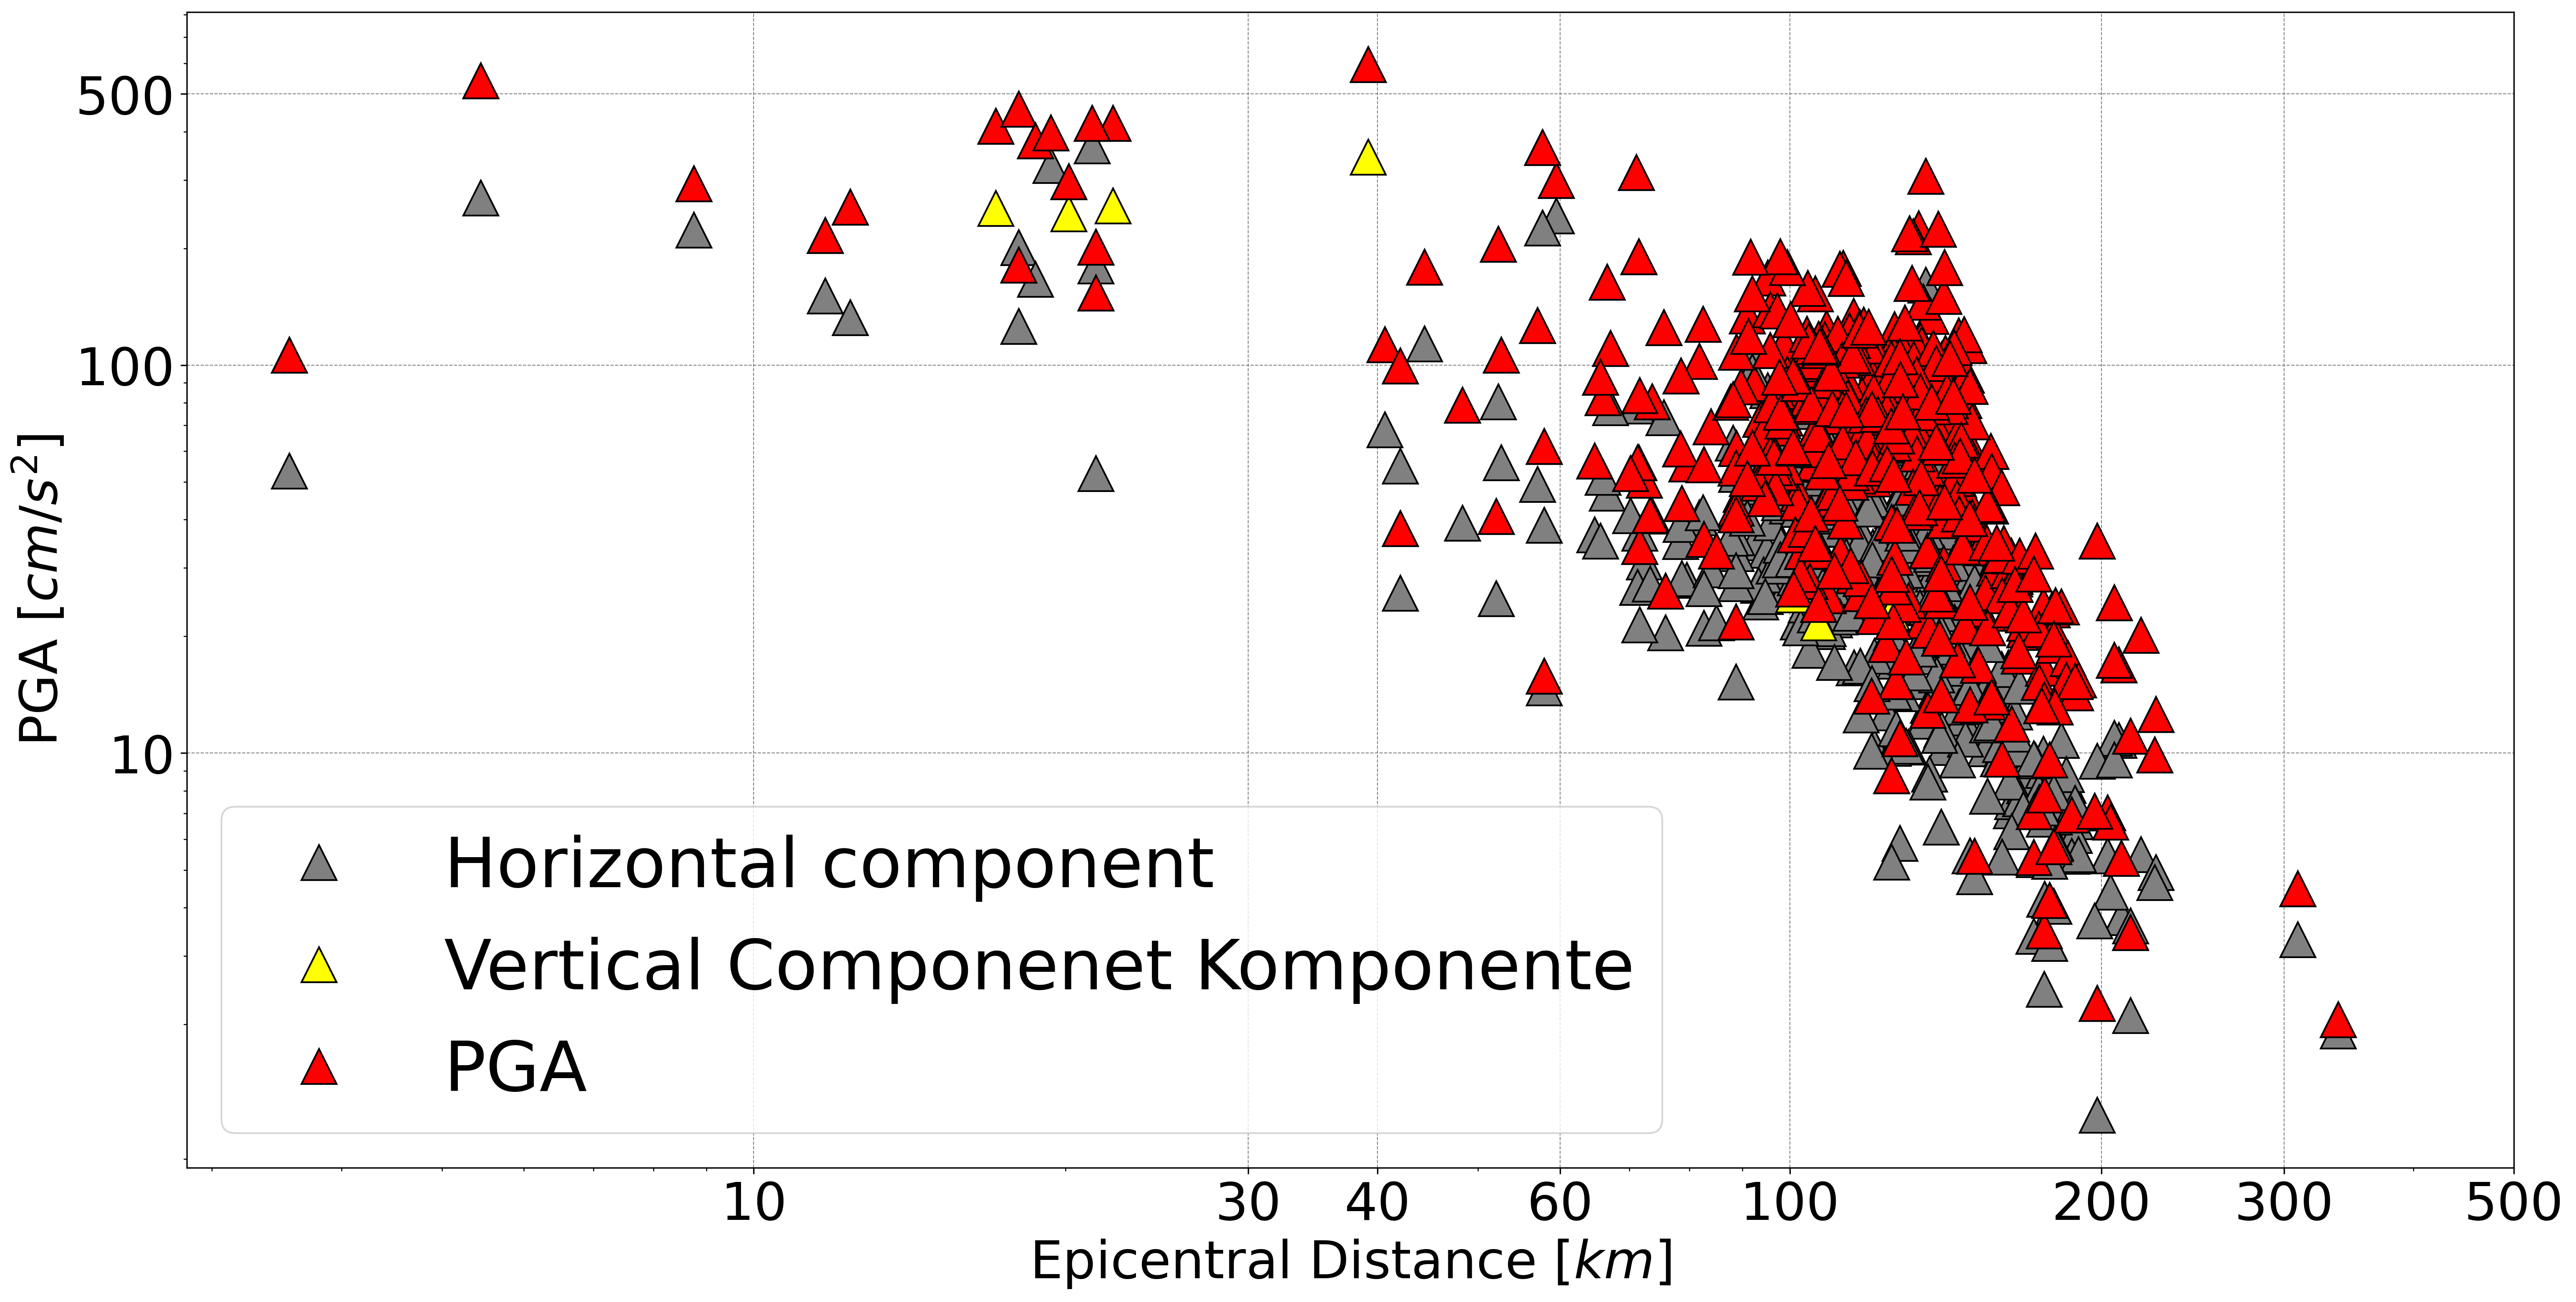

In [13]:
import matplotlib.ticker as ticker


plt.style.use('./bins/instruments_data.mplstyle')


plt.plot(instruments_data['distance'],
                              instruments_data['HNZ'],
                              'k^',mfc='gray',markersize=20, label = 'Horizontal component')

plt.plot(instruments_data['distance'],
                              instruments_data['MaxH'],
                              'k^',mfc='yellow',markersize=20, label = 'Vertical Componenet Komponente')

plt.plot(instruments_data['distance'],
                              instruments_data['pga'],
                              'k^',mfc='r',markersize=20, label = 'PGA')


plt.grid()
plt.legend()

# set axis scale 
plt.xscale('log', base=10)
plt.yscale('log',base=10)

# Customize tick labels to scalar format
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Ensure that every tick label is formatted in scalar (no scientific notation)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_scientific(False)


#set label sizes 
plt.xlabel('Epicentral Distance [$km$]', fontsize=30)
plt.ylabel('PGA [$cm/s^2$]', fontsize=30)

#axis bounds 
ticksx = [10,30, 40, 60, 100, 200, 300,500]
ticksy = [10,100,500]

plt.xticks(ticksx)
plt.yticks(ticksy)

#plt.savefig('Bild2_Page2_Var2_SeismicStationRecorda.png', bbox_inches='tight', dpi=300)



## DYFI?  Data

### Parse DYFI? data from .xml 

In [14]:

parser = USGSParser(parser_type='dyfi_data', mode='parse', xml_file=file_path_dyfixml)
dyfi_data = parser.to_dataframe()

dyfi_data



,code,lat,lon,netid,dist,intensity,intensity_stddev,nresp,source
0,DYFI.UTM:(48R 0780 2731 1000),24.6723,107.7717,DYFI,1404.0,3.1,0.5298,1,USGS (Did You Feel It?)
1,DYFI.UTM:(49Q 0223 2532 1000),22.8776,108.3051,DYFI,1360.0,2.0,0.5298,1,USGS (Did You Feel It?)
2,DYFI.UTM:(50Q 0198 2496 1000),22.5485,114.0686,DYFI,780.0,2.2,0.5298,1,USGS (Did You Feel It?)
3,DYFI.UTM:(50Q 0209 2470 1000),22.3158,114.1802,DYFI,775.0,2.7,0.5298,1,USGS (Did You Feel It?)
4,DYFI.UTM:(50Q 0210 2468 1000),22.2979,114.1902,DYFI,774.0,2.7,0.5298,1,USGS (Did You Feel It?)
...,...,...,...,...,...,...,...,...,...
319,DYFI.UTM:(51S 0266 3994 1000),36.0671,120.4073,DYFI,1362.0,3.4,0.5298,1,USGS (Did You Feel It?)
320,DYFI.UTM:(52R 0376 2909 1000),26.3000,127.7629,DYFI,684.0,1.0,0.5298,1,USGS (Did You Feel It?)
321,DYFI.UTM:(53S 0538 3853 1000),34.8230,135.4210,DYFI,1816.0,3.8,0.5298,1,USGS (Did You Feel It?)
322,DYFI.UTM:(54S 0376 3923 1000),35.4473,139.6392,DYFI,2174.0,1.0,0.5298,1,USGS (Did You Feel It?)


### Create DYFI? .xml data from .csv

In [15]:
creator = USGSParser(parser_type='dyfi_data', mode='create', csv_file=file_path_dyficsv,event_id=event_id)

df = creator.to_dataframe()
#creator.write_dyfi_xml()

CSV loaded with 324 rows.


## Parse Rupture information 

In [16]:
# Example usage
file_path_rupturedata = './example_data/us7000m9g4/current/rupture.json'  # Replace with actual file path

parser = USGSParser(parser_type='rupture_json', mode='parse',rupture_json=file_path_rupturedata)
#parser = USGSParser(data_type='rupture_data',mode='parse',event_id='us6000jllz')

metadata = parser.get_metadata()
coordinates = parser.get_rupture_coordinates()
print("Metadata:", metadata)
print("Coordinates:", coordinates)


Metadata: {'event_id': 'us7000m9g4', 'network': 'USGS National Earthquake Information Center, PDE', 'product_code': 'us7000m9g4', 'event_time': '2024-04-02T23:58:11.000000Z', 'location': '18 km SSW of Hualien City, Taiwan, TW', 'magnitude': 7.4, 'depth': 34.8}
Coordinates: [[[[121.37, 23.8, 7.93], [121.55, 24.14, 7.93], [121.81, 24.02, 55.73], [121.63, 23.68, 55.73], [121.37, 23.8, 7.93]]]]


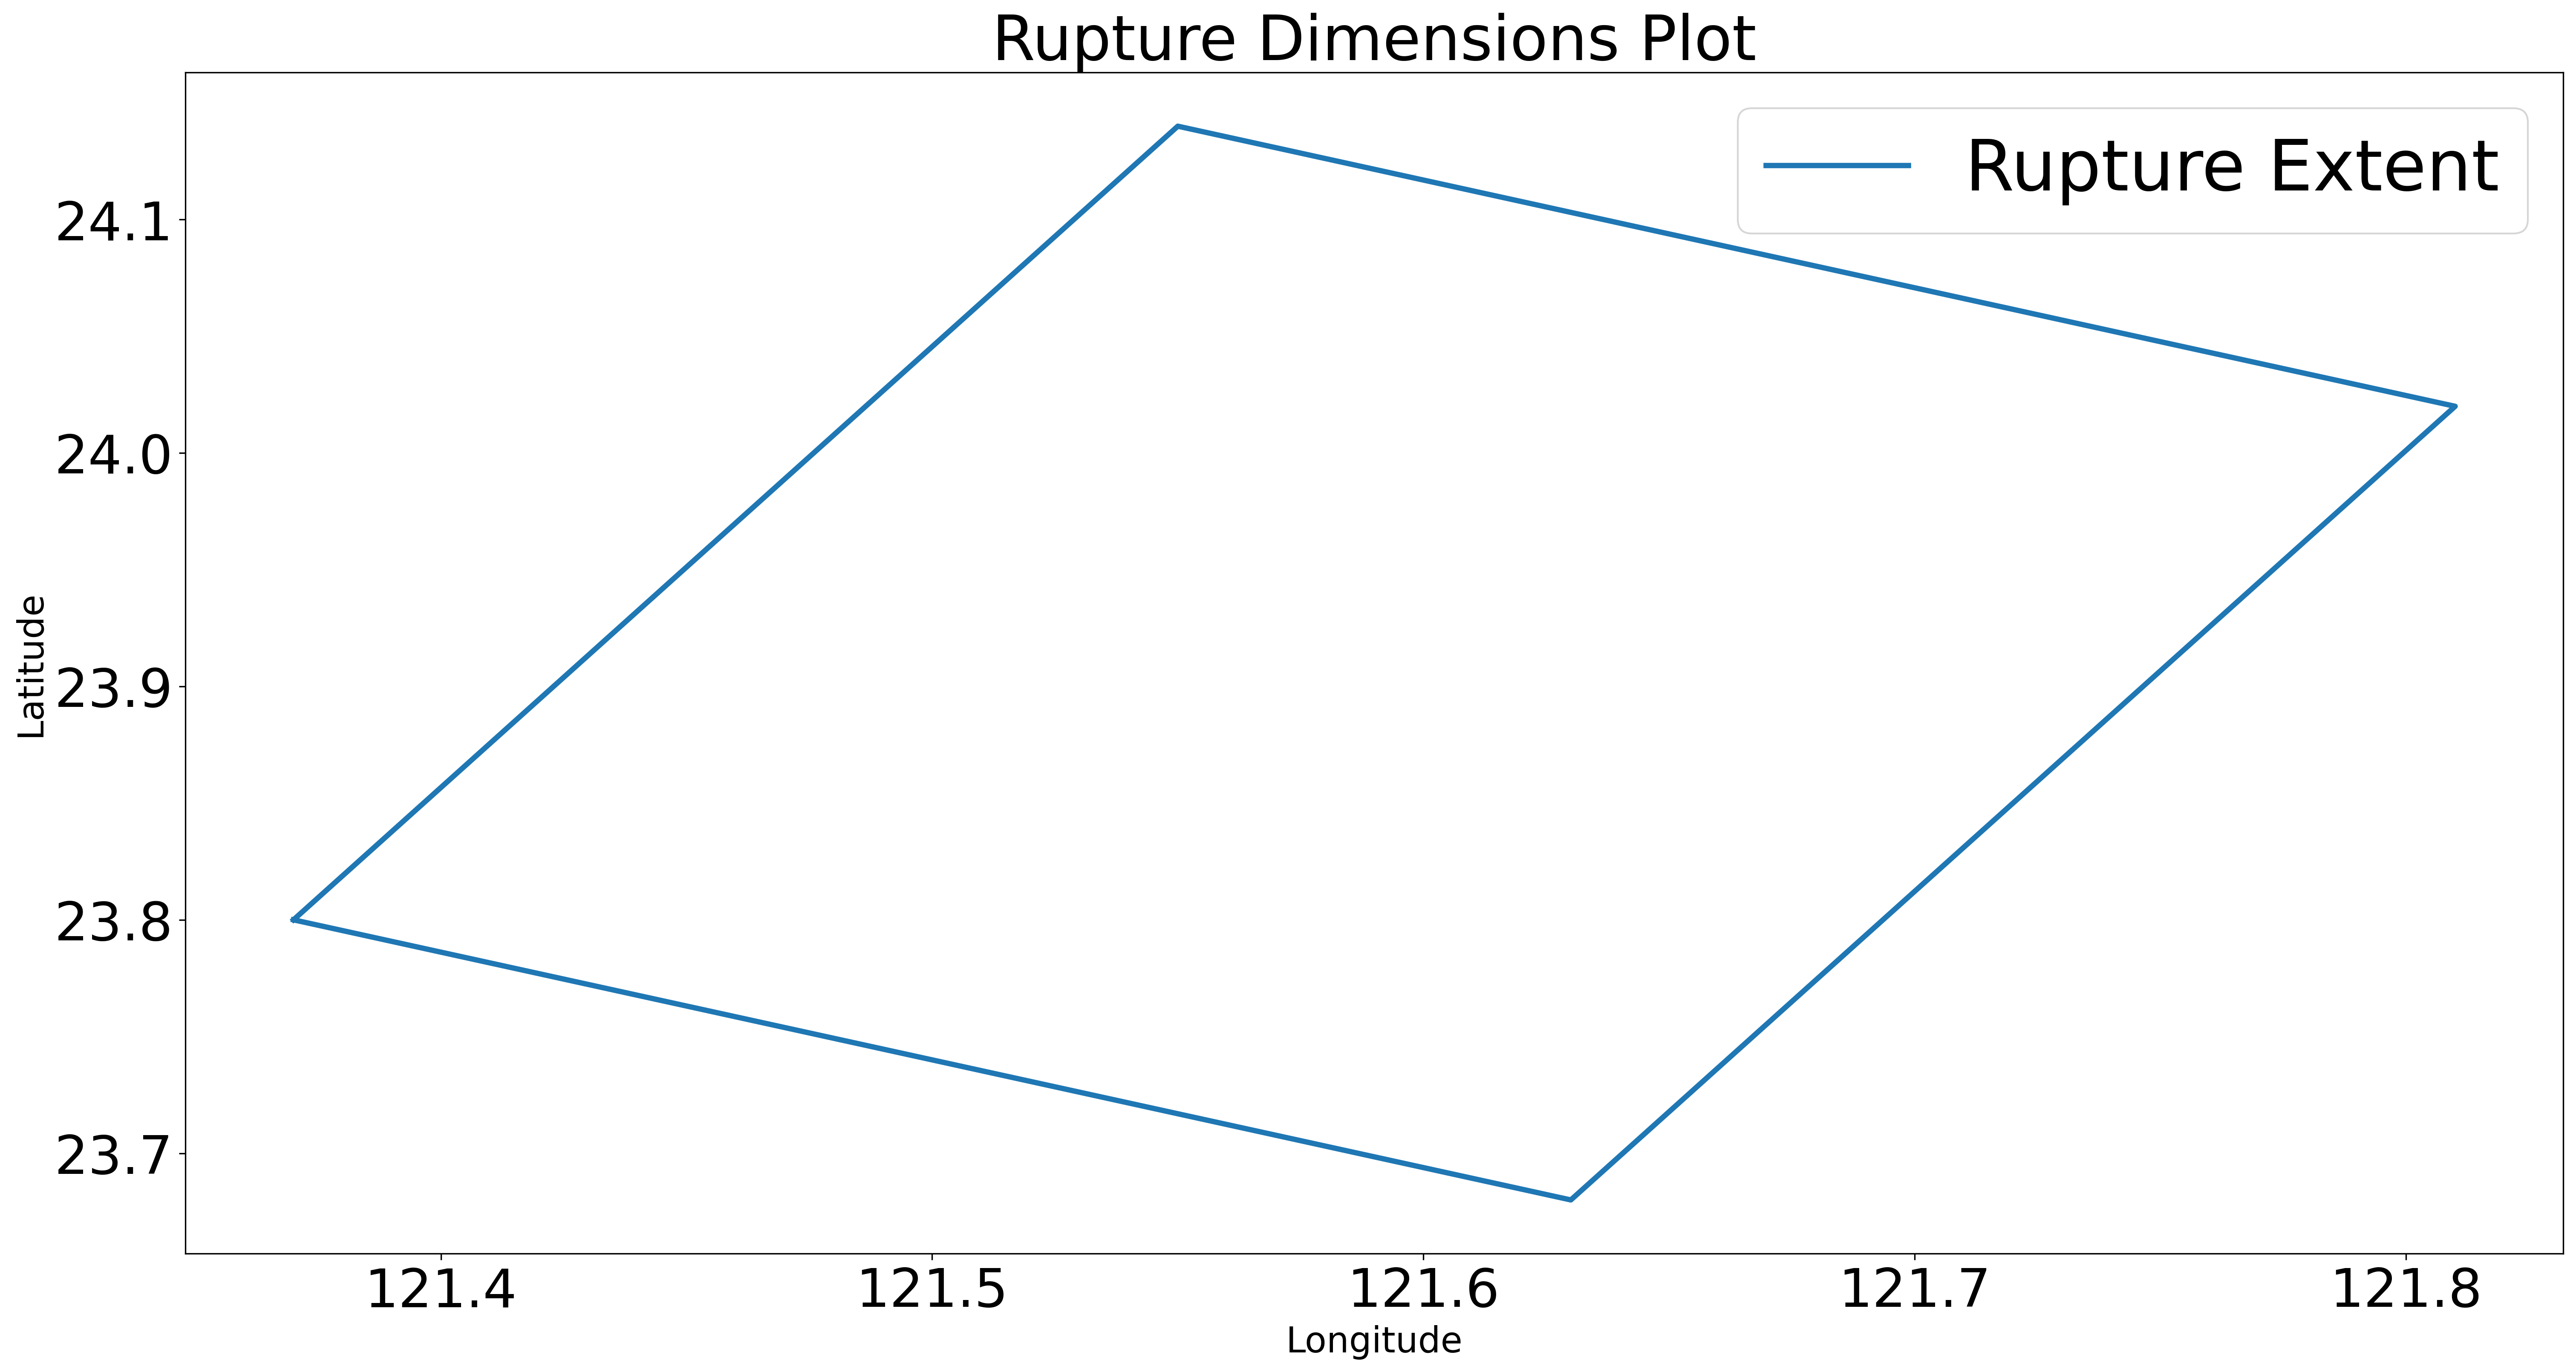

In [17]:
# Extract rupture coordinates
x_coords, y_coords = parser.get_rupture_xy()

# Plotting function
fig, ax = plt.subplots()
ax.plot(x_coords, y_coords, '-', label='Rupture Extent')
ax.set_title('Rupture Dimensions Plot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

## Parse Shakemap Data 


### View the shakemap 

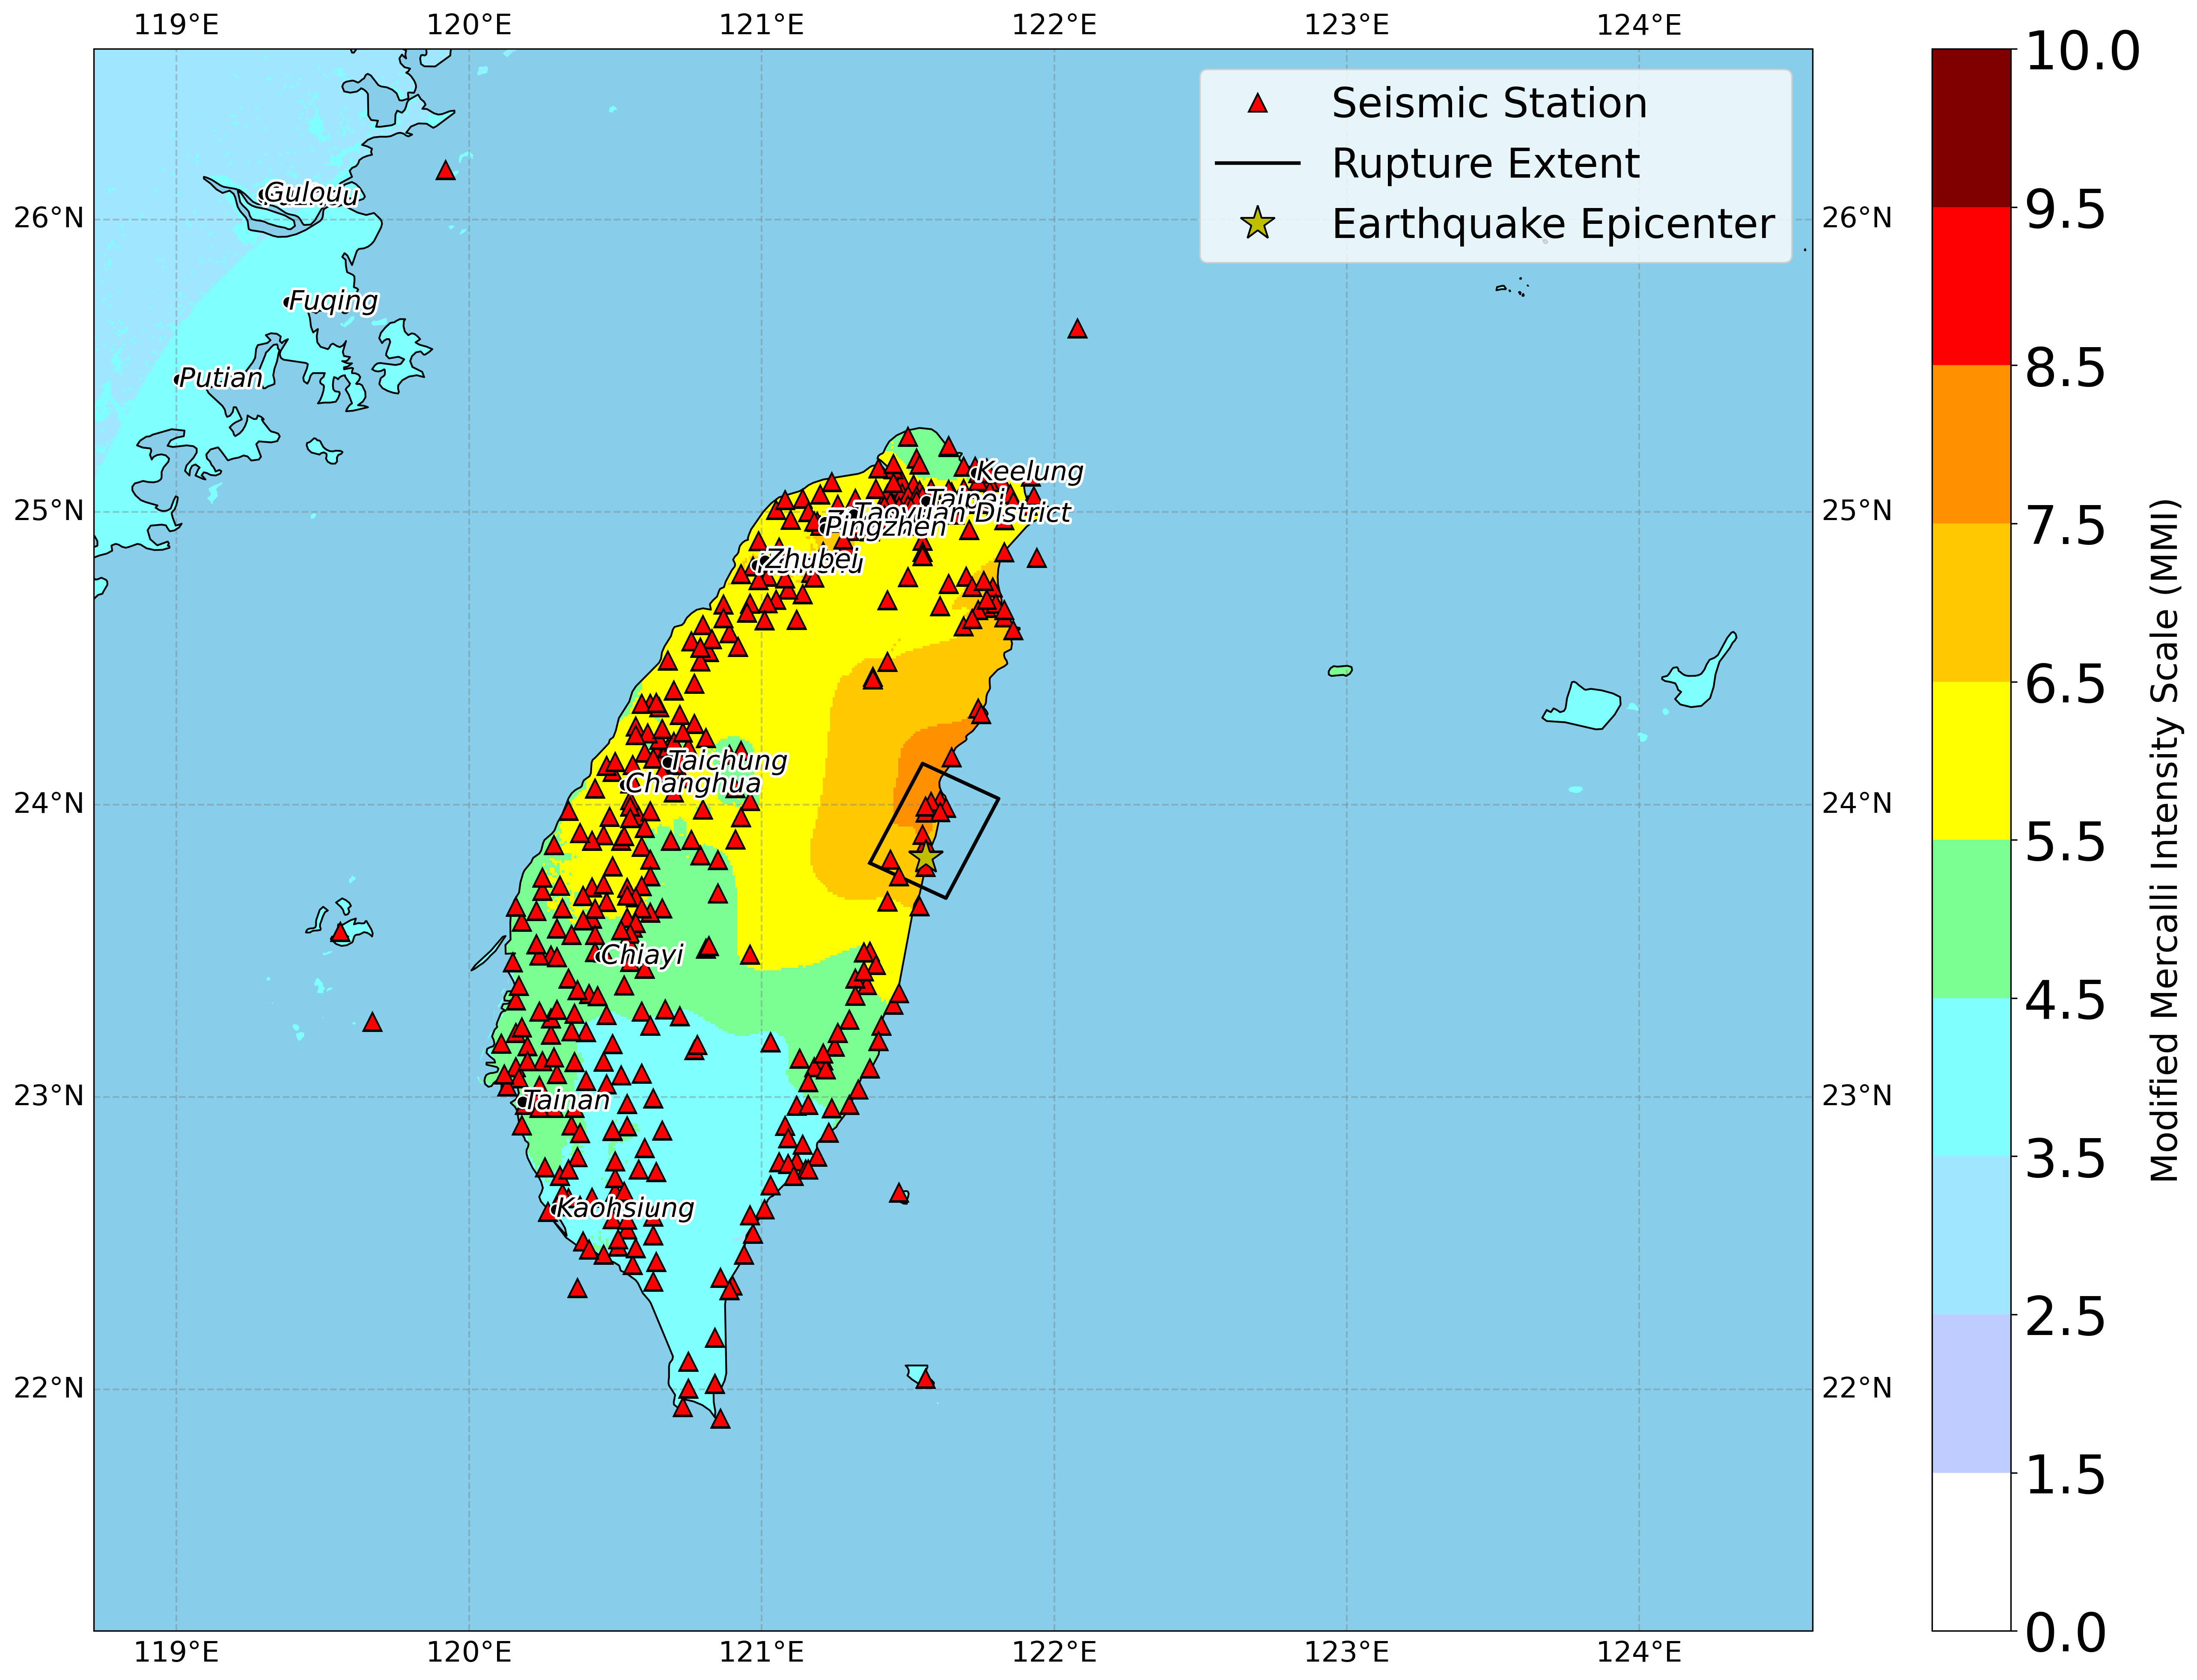

In [26]:
shakemap_parser_zip = USGSParser(parser_type="shakemap_raster",zip_file=raster_shakemap_file_path, map_type="mmi", data_type="mean")


fig,ax = shakemap_parser_zip.plot_shakemap()


shakemap_parser_zip.add_stations(fig,ax,instruments_data['longitude'],instruments_data['latitude'] )

shakemap_parser_zip.add_cities(fig, ax,200000)



x_coords, y_coords = parser.get_rupture_xy()
shakemap_parser_zip.add_rupture(fig,ax,x_coords,y_coords )

x_coords, y_coords = event_df['lon'],event_df['lat']
shakemap_parser_zip.add_epicenter(fig,ax,x_coords,y_coords)


ax.legend(loc='upper right', fontsize='x-large')




shakemap_parser_zip.cleanup()


In [19]:
cities = shakemap_parser_zip.get_cities()
cities

,city_name,city_ascii,Latitude,Longitude,country,iso2,iso3,admin_name,capital,population,id
202,Fuzhou,Fuzhou,26.0743,119.2964,China,CN,CHN,Fujian,admin,3671192.0,1156188037
238,Putian,Putian,25.4526,119.0078,China,CN,CHN,Fujian,minor,3210714.0,1156811601
254,Taichung,Taichung,24.1439,120.6794,Taiwan,TW,TWN,Taichung,admin,3033885.0,1158689622
289,Kaohsiung,Kaohsiung,22.6150,120.2975,Taiwan,TW,TWN,Kaohsiung,admin,2733964.0,1158331334
308,Gulou,Gulou,26.0865,119.2980,China,CN,CHN,Fujian,minor,2606000.0,1156680279
...,...,...,...,...,...,...,...,...,...,...,...
42973,Xinpi,Xinpi,22.4880,120.5814,Taiwan,TW,TWN,Pingtung,NaN,9528.0,1158537415
44507,Nanzhuang,Nanzhuang,24.5699,121.0157,Taiwan,TW,TWN,Miaoli,NaN,9029.0,1158569080
45933,Beibu,Beibu,24.6639,121.0681,Taiwan,TW,TWN,Hsinchu,NaN,8633.0,1158656385
46495,Nangan,Nangan,26.1500,119.9333,Taiwan,TW,TWN,Lienchiang,admin,7382.0,1158327079


### view uncertainties 

(<Figure size 7200x4800 with 2 Axes>, <GeoAxes: >)

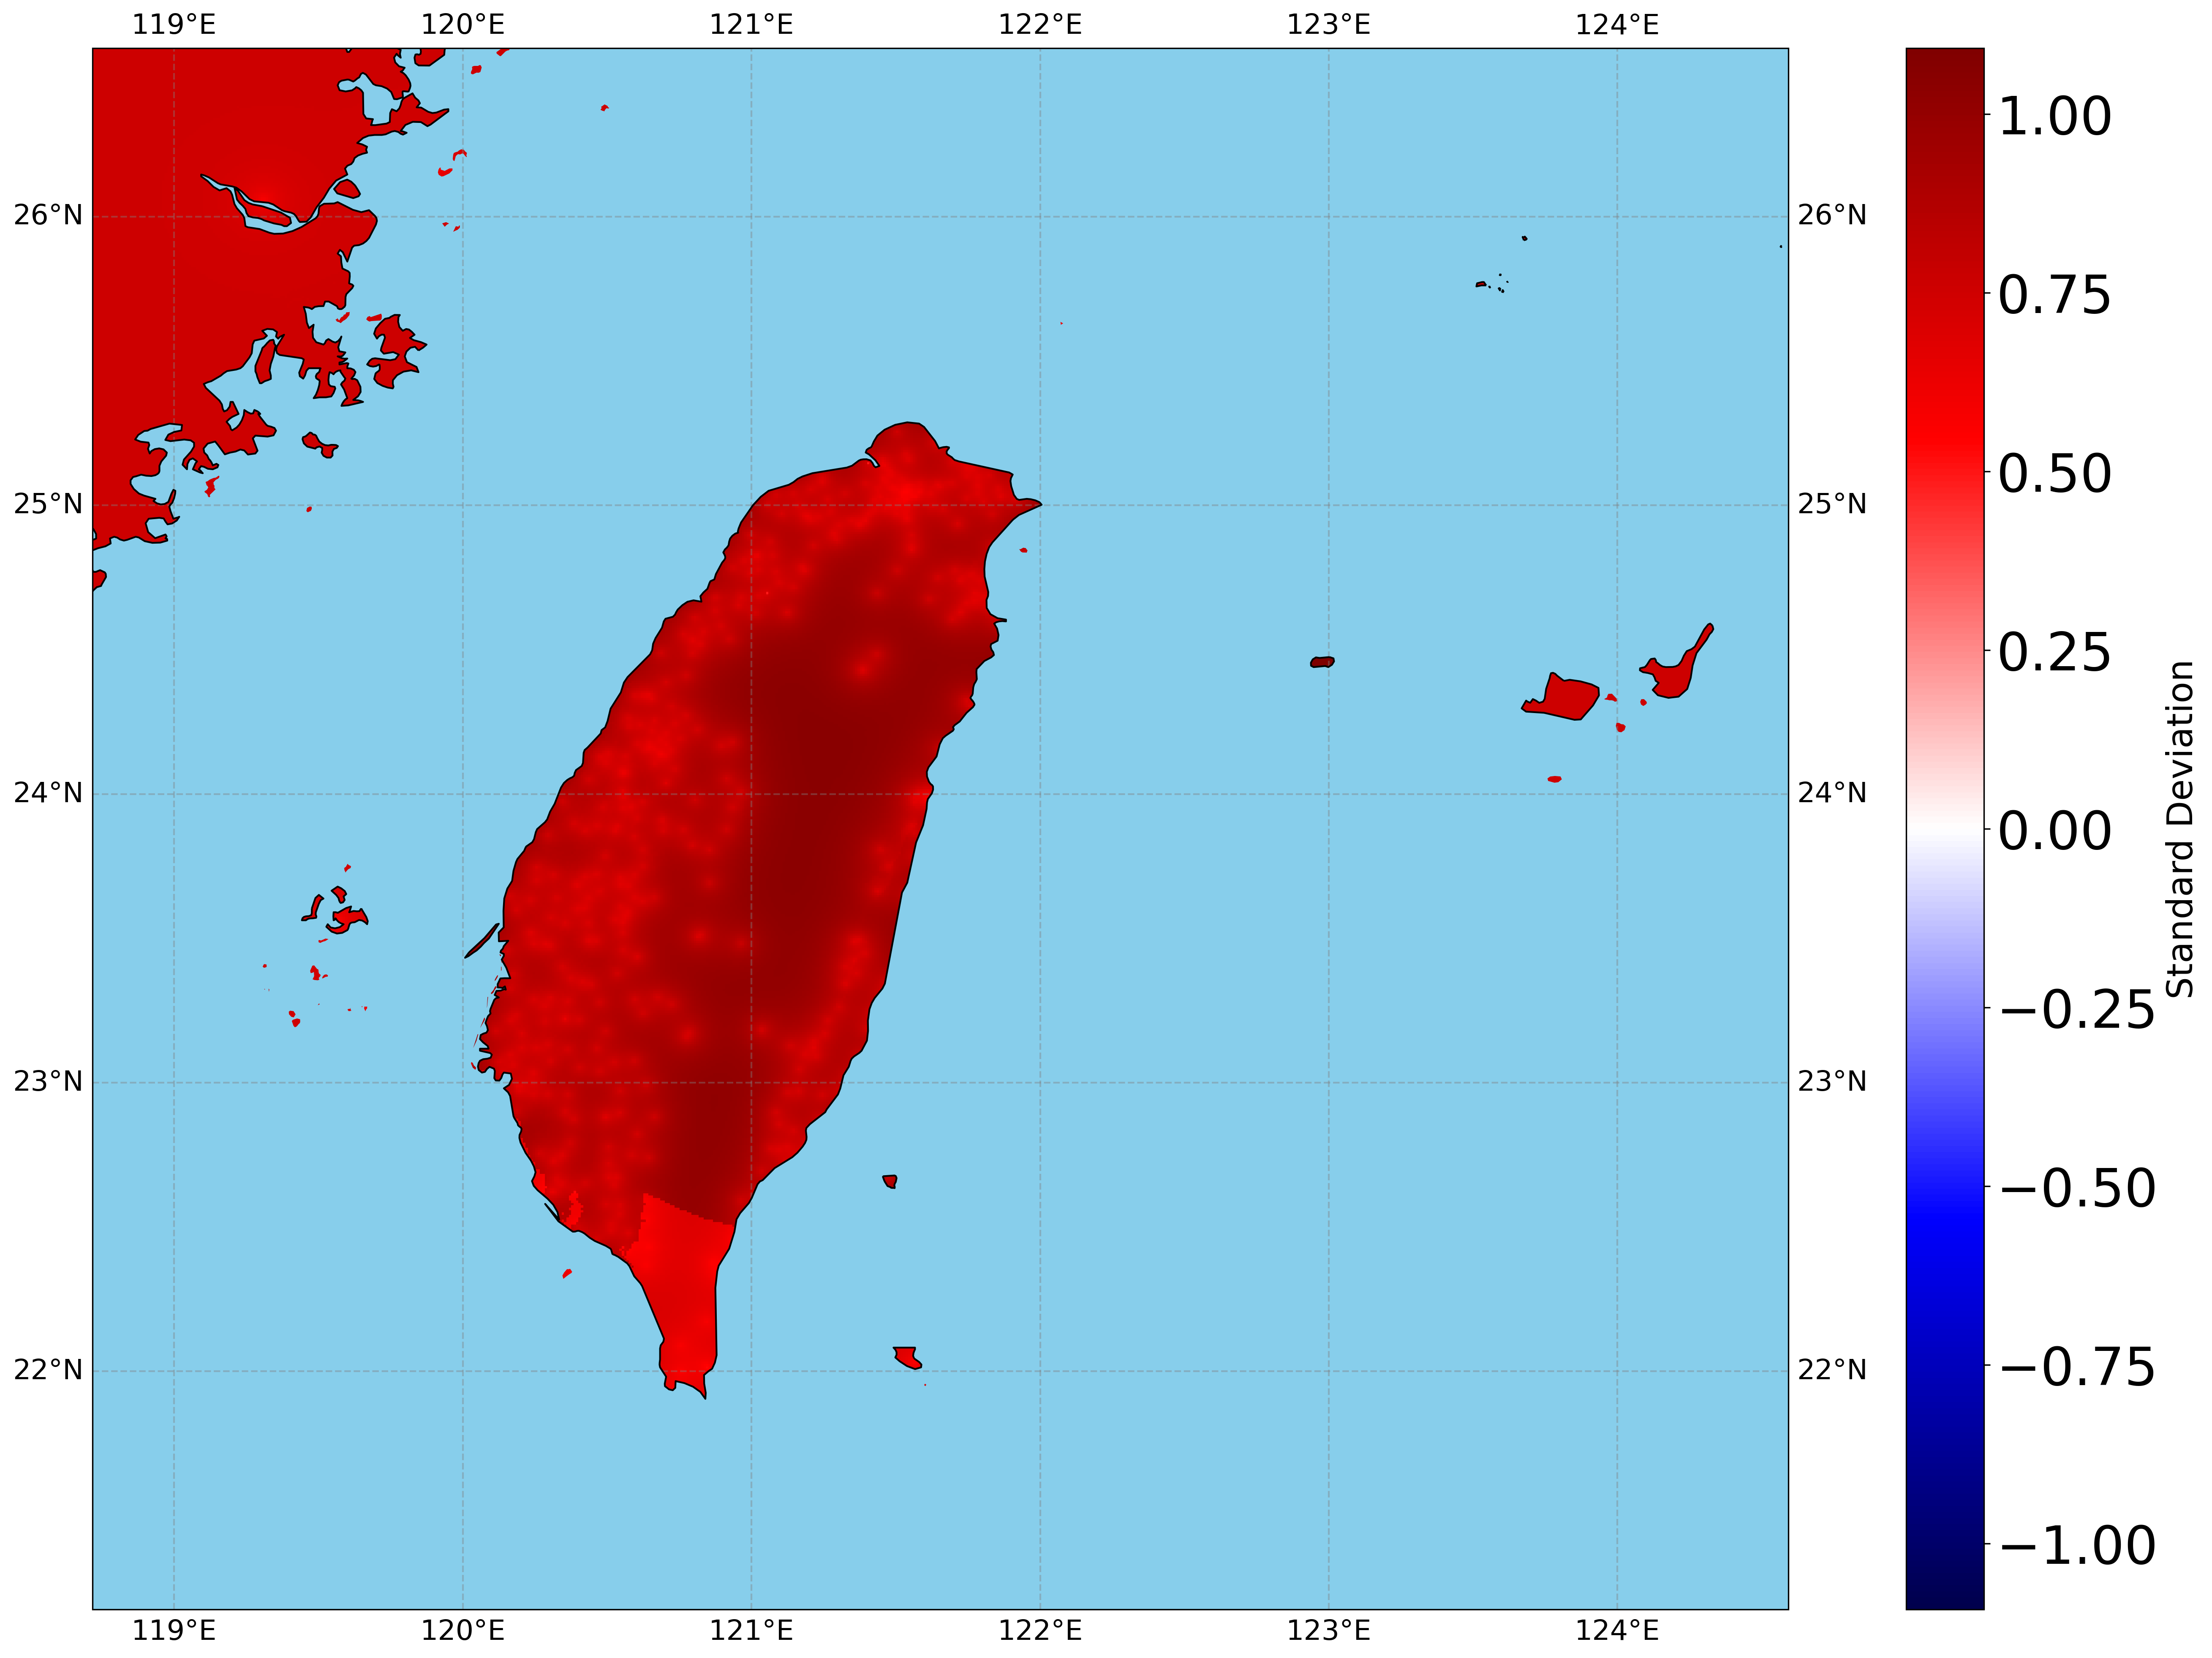

In [20]:
shakemap_parser_zip = USGSParser(parser_type="shakemap_raster",zip_file=raster_shakemap_file_path, map_type="mmi", data_type="std")

shakemap_parser_zip.plot_shakemap()

## Parse Pager data

In [21]:
# Example usage:

pager_parser = USGSParser(parser_type='pager',mode='parse', xml_file=file_path_pagerxml)
event_details = pager_parser.get_pager_details()
alerts = pager_parser.get_alerts()
cities_impact = pager_parser.get_cities_impact()
comments = pager_parser.get_structural_comments()

print(event_details)
print(alerts)
print(cities_impact)
print(comments)


{'eventcode': 'us7000m9g4', 'versioncode': 'us7000m9g4', 'number': '10', 'shakeversion': '11', 'magnitude': '7.4', 'depth': '40.0', 'lat': '23.8353', 'lon': '121.5977', 'event_timestamp': '2024-04-02 23:58:12', 'event_description': '15 km S of Hualien City, Taiwan', 'maxmmi': '8.0', 'shaketime': '2024-05-09 23:30:37', 'isreviewed': 'False', 'localtime': '2024-04-03 07:58:12'}
[{'type': 'economic', 'level': 'yellow', 'summary': 'yes', 'bins': [{'min': '0', 'max': '1', 'probability': '0.05', 'color': 'green'}, {'min': '1', 'max': '10', 'probability': '0.19', 'color': 'yellow'}, {'min': '10', 'max': '100', 'probability': '0.35', 'color': 'yellow'}, {'min': '100', 'max': '1000', 'probability': '0.29', 'color': 'orange'}, {'min': '1000', 'max': '10000', 'probability': '0.11', 'color': 'red'}, {'min': '10000', 'max': '100000', 'probability': '0.02', 'color': 'red'}, {'min': '100000', 'max': '10000000', 'probability': '0.00', 'color': 'red'}]}, {'type': 'fatality', 'level': 'yellow', 'summary

In [22]:
# converting pager data to dataframes 
# Example usage:
#pager_parser = ParsePagerDataXML(xml_path)
dataframes = pager_parser.to_dataframe()

#print(dataframes['Event Details'])
#print(dataframes['Alerts'])
print(dataframes['Cities Impact'])
#print(dataframes['Comments'])

             name      lat       lon population  mmi iscapital
0    Hualien City  23.9769  121.6044     350468  7.4         0
1           Yilan  24.7570  121.7530      94188  7.2         0
2         Banqiao  25.0143  121.4672     543342  6.7         0
3            Daxi  24.8837  121.2904      84549  6.7         0
4          Zhubei  24.8383  121.0078          0  6.6         0
..            ...      ...       ...        ...  ...       ...
238     Jiayi Shi  23.4792  120.4489          0  5.1         0
239     Chang-hua  24.0733  120.5628          0  5.9         0
240  Taoyuan City  24.9937  121.2970     402014  6.4         0
241  Taitung City  22.7583  121.1444     109584  4.2         0
242        Nangan  26.1504  119.9328          0  3.5         0

[243 rows x 6 columns]


(<Figure size 3600x1800 with 1 Axes>,
 <Axes: title={'center': 'Estimated Fatality Probability Distribution'}, xlabel='Fatalities', ylabel='Probability'>)

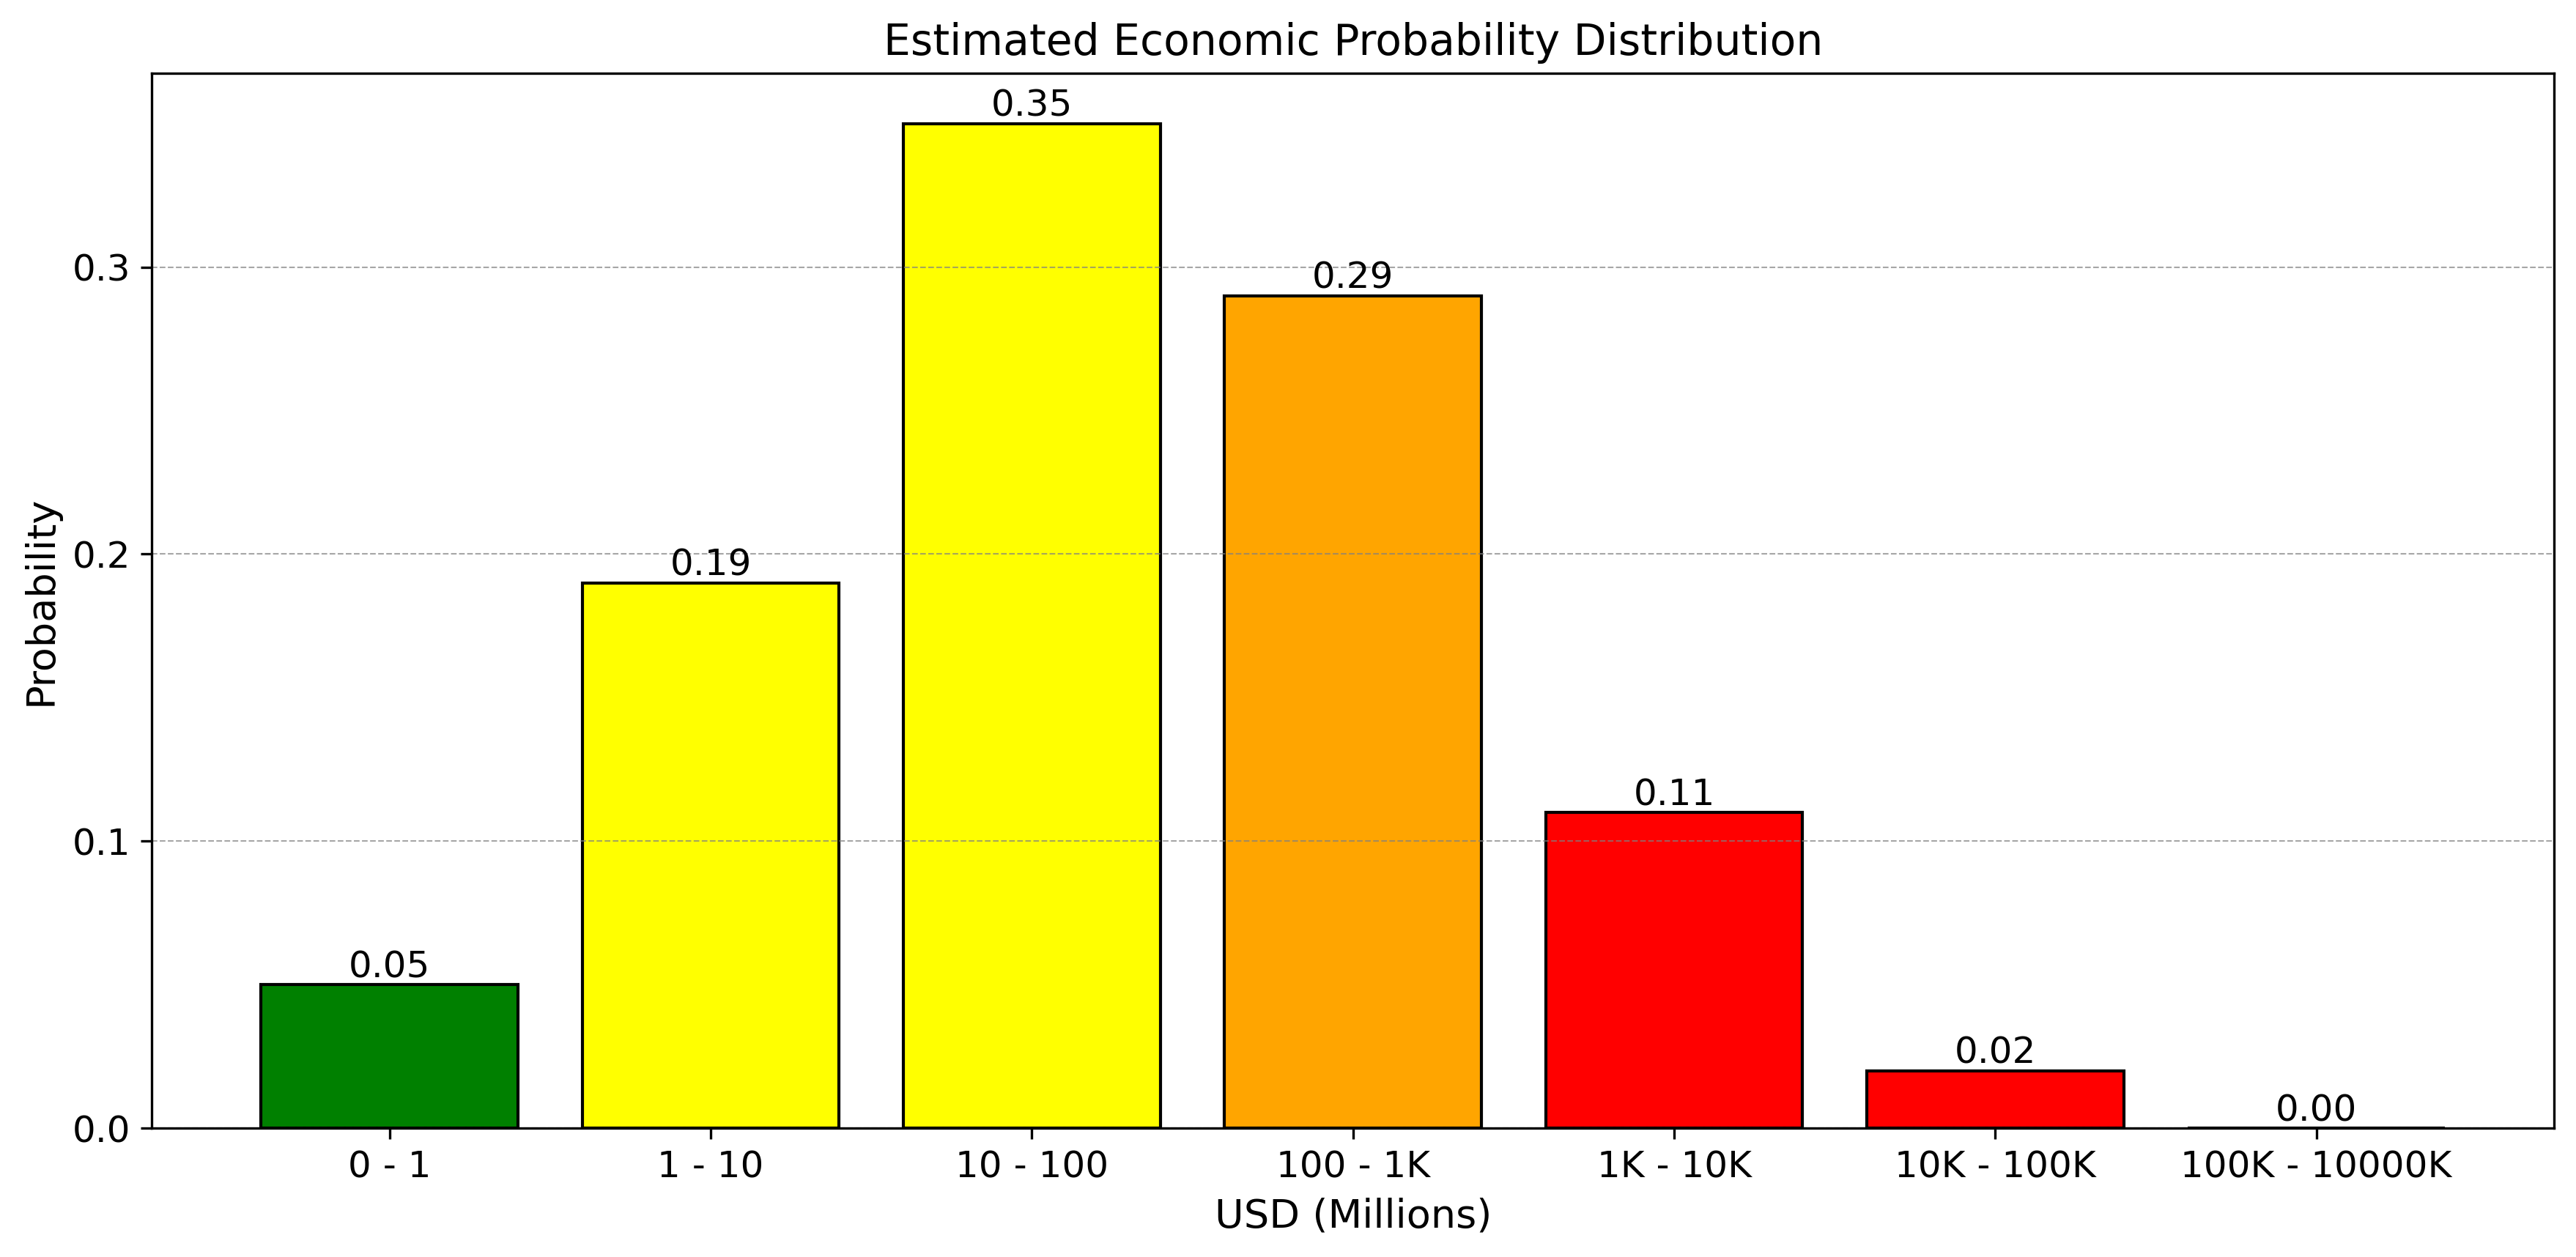

<Figure size 15000x12000 with 0 Axes>

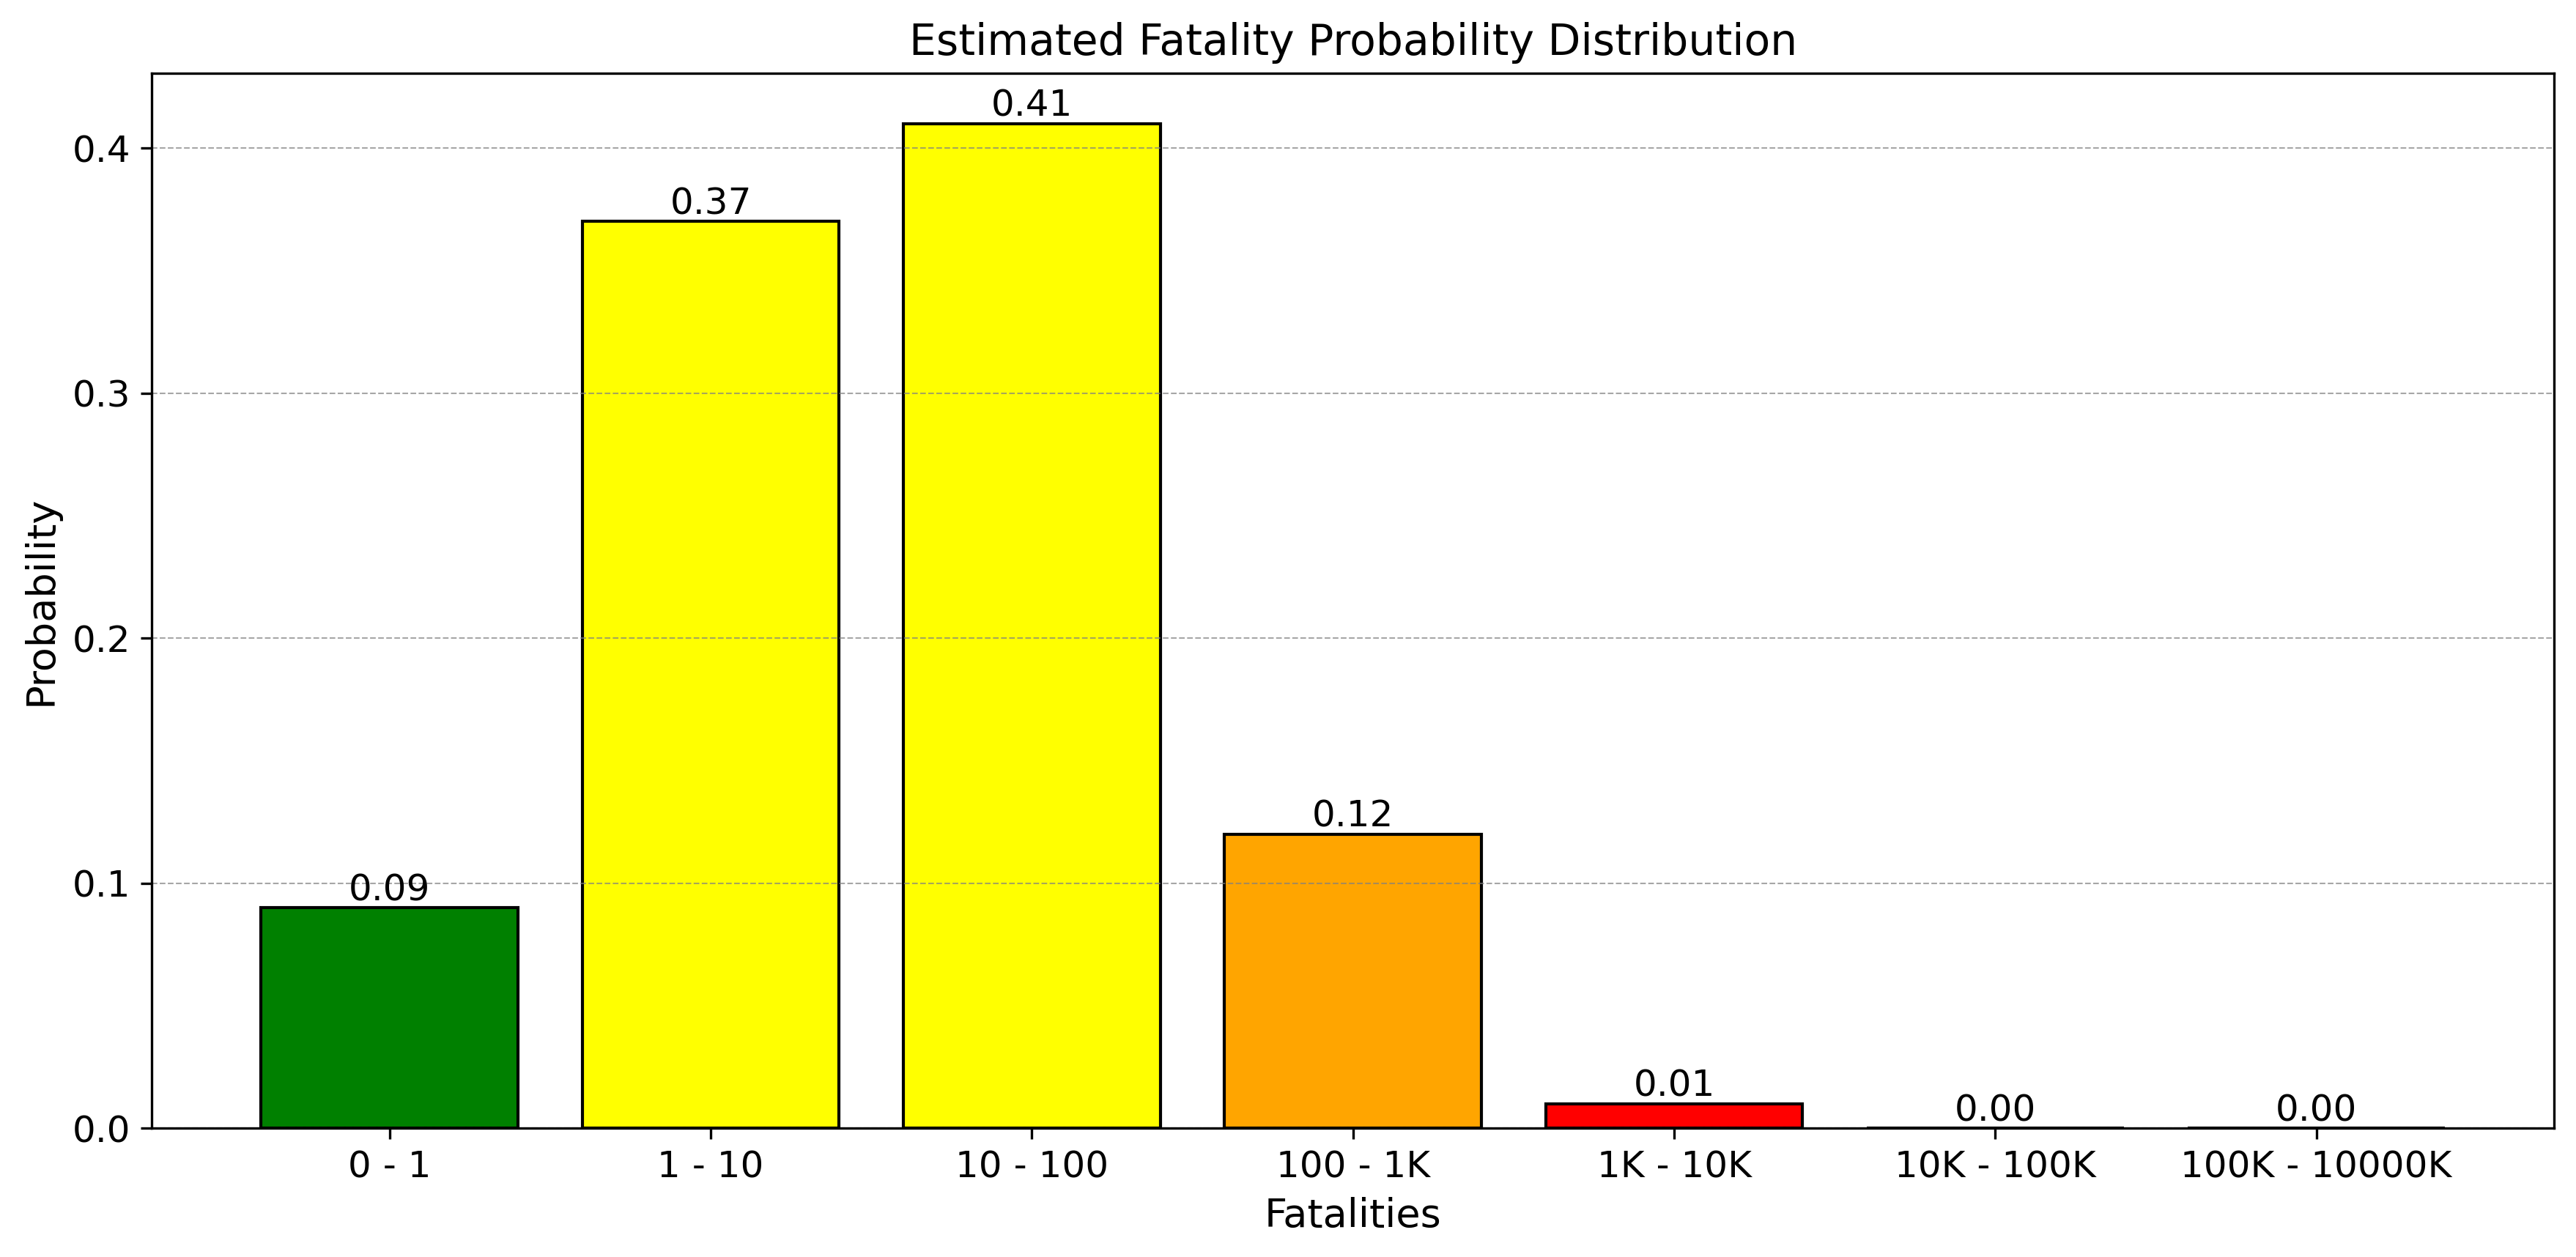

In [23]:
# Generate the plot and get the figure object
fig, ax = pager_parser.plot_probability_distribution('economic')

plt.figure(figsize=(50, 40))

#fig.savefig('paer.png', format='png', dpi=300)

pager_parser.plot_probability_distribution('fatality')
